In [4]:
import sys, os
from utils_nn import softmax, cross_entropy_error, sigmoid
sys.path.insert(0, '../GD/')
from GD_common import numerical_gradient
import collections

## **단순 신경망 구현**

In [3]:
class simpleNet(object):
    def __init__(self):
        self.W = np.random.normal(size=(2,3))
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [6]:
x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])
nn = simpleNet()
nn.W

array([[ 0.47210107, -1.07798534,  0.85648856],
       [-1.54253597, -1.10336889,  0.32830708]])

In [8]:
p = nn.predict(x)
p

array([-1.10502173, -1.6398232 ,  0.80936951])

In [9]:
np.argmax(p)

2

In [10]:
nn.loss(x, t)

2.6592859352182034

In [14]:
f = lambda w: nn.loss(x, t)

In [13]:
dW = numerical_gradient(f, nn.W)
dW

array([[ 0.07169653, -0.55800035,  0.48630382],
       [ 0.10754479, -0.83700053,  0.72945573]])

## **2층 신경망 학습**

![fig1](./figs/NN_3.png)

(그림 과 같은 건 아님)
* Input Size: m
* Hidden Size: h
* Output Size: o
$$ X_{(batch,\ m)} \cdot W1_{(m,\ h)} + B1_{(batch,\ h)} \rightarrow A1_{(batch,\ h)} $$
$$ sigmoid(A1_{(batch,\ h)}) \rightarrow Z1_{(batch,\ h)}$$
$$ Z1_{(batch,\ h)} \cdot W1_{(h,\ o)} + B1_{(batch,\ o)} \rightarrow A2_{(batch,\ o)} $$
$$ \sigma(A2_{(batch,\ o)}) \rightarrow Y_{(batch,\ o)}$$

In [16]:
from dataset.mnist import load_mnist
from two_layer_nn import TwoLayer
import time

In [11]:
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

#highper parameter
epoch_num = 1
train_size = x_train.shape[0]
batch_size = 100
alpha = 0.1  # learning rate
epsilon = 1e-6

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
nn = TwoLayer(input_size=784, hidden_size=100, output_size=10)

In [21]:
start = time.time()
for epoch in range(epoch_num):
    # get mini batch: 
    batch_mask = np.random.choice(train_size, batch_size) # shuffle 효과
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    # gradient 계산
    grad = nn.num_gradient(x_batch, y_batch)
    
    # update
    for key in ['W1', 'b1', 'W2', 'b2']:
        nn.params[key] = nn.params[key] - alpha * grad[key]
    
    # record
    loss = nn.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if epoch % iter_per_epoch == 0:
        train_acc = nn.accuracy(x_train, y_train)
        test_acc = nn.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('trian acc: {0:.5f} | test acc: {1:.5f}'.format(train_acc, test_acc))
        
    # stop point
    if epoch > 10:
        stop_point = np.sum(np.diff(np.array(train_loss_list[i-11:])) < epsilon)
        if stop_point == 10:
            print(epoch)
            break

end = time.time()
print('total time:', (start - end))

trian acc: 0.09750 | test acc: 0.09740


KeyboardInterrupt: 

## **backpropagation**

### **연쇄법칙의 원리**
합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.

$$\begin{cases} z = t^2\\ t = x + y \end{cases}$$

위 식의 미분을 나타내면
$$ \frac{\partial{z}}{\partial{x}} = \frac{\partial{z}}{\partial{t}} \cdot \frac{\partial{t}}{\partial{x}} $$

$$\frac{\partial{z}}{\partial{t}} = 2t\\ \frac{\partial{t}}{\partial{x}}=1 $$

$$\therefore\  \frac{\partial{z}}{\partial{x}} = \frac{\partial{z}}{\partial{t}} \cdot \frac{\partial{t}}{\partial{x}} = 2t \cdot 1 = 2(x+y)$$

$$\frac{\partial{L}}{\partial{W}} = \frac{\partial{L}}{\partial{Y}} \cdot \frac{\partial{Y}}{\partial{W}}$$

<img src="./figs/NN_add.png" alt="Drawing" style="width: 400px;"/>

덧셈 노드는 들어온 신호를 그대로 보낸다 

<img src="./figs/NN_multiply.png" alt="Drawing" style="width: 400px;"/>

곱셈 노드는 들어온 신호에 서로 바뀐 입력신호 값을 곱해서 하류로 보낸다

### **sigmoid 계층**

$$ y = \frac{1}{1+\exp(-x)}$$

![](./figs/NN_sigmoid_forward.png)

![](./figs/NN_sigmoid_back.png)
![](./figs/NN_sigmoid_back2.png)

#### **역전파 1단계 ( / )**
"/" 연산은 입력변수 x를 $\frac{1}{x}$ 로 바꿔준다. 즉 $ f1(x) = \frac{1}{x}$ 가 된다.

미분을 하게 되면 $\frac{\partial{f1}}{\partial{x}} = -\frac{1}{x^2} = -y^2$가 되서 입력신호를 하류로 보낸다

#### **역전파 2단계 ( + )**
"+" 연산은 신호를 그대로 하류로 흘러 보낸다

#### **역전파 3단계 (exp)**
"exp"연산은 $f2(x) = exp(x)$ 이며, 미분도 $\frac{\partial{f2}}{\partial{x}} = exp(x)$ 로 그대로 곱해서 하류로 보낸다.

#### **역전파 4단계 ( x )**
"$\times$"연산은 서로 바뀐 입력신호의 값을 곱해서 보낸다.

따라서,
![](./figs/NN_sigmoid_last.png)

최종적으로 시그모이드의 역전파 출력값은  

$$ \frac{\partial{L}}{\partial{y}}y^{2}\exp(-x)\\ 
= \frac{\partial{L}}{\partial{y}} \frac{1}{[1+\exp(-x)]^2}\exp(-x) \\
= \frac{\partial{L}}{\partial{y}} \frac{1}{1+\exp(-x)} \frac{\exp(-x)}{1+\exp(-x)} \\
= \frac{\partial{L}}{\partial{y}}y(1-y)
$$

### **Affine / Softmax 계층**

#### **Affine Transform**
기하학에서 신경망 순전파 때 수행하는 행렬의 내적, Affine 계층은 어파인 변환을 수행 처리하는 계층임


sympy미분

In [1]:
import sympy
from sympy.tensor.array import *
# Juypter 노트북에서 수학식의 LaTeX 표현을 위해 필요함
sympy.init_printing(use_unicode=False, wrap_line=False, no_global=True, use_latex='mathjax')
from sympy.matrices import Matrix
w11, w12, w21, w22, w31, w32 = sympy.symbols(('w11', 'w12', 'w21', 'w22', 'w31', 'w32'))
x1, x2 = sympy.symbols(('x1', 'x2'))
y1 = sympy.Function('y1')(w11*x1 + w12*x2)
y2 = sympy.Function('y2')(w21*x1 + w22*x2)
y3 = sympy.Function('y3')(w31*x1 + w32*x2)
Y = Matrix([y1, y2, y3])
W = Matrix([[w11, w12],
            [w21, w22],
            [w31, w32]])
X = Matrix([x1, x2])

In [2]:
Y

[y1(w11*x1 + w12*x2)]
[                   ]
[y2(w21*x1 + w22*x2)]
[                   ]
[y3(w31*x1 + w32*x2)]

In [3]:
W

[w11  w12]
[        ]
[w21  w22]
[        ]
[w31  w32]

In [4]:
X

[x1]
[  ]
[x2]

In [5]:
derive_by_array(Y, W)

[[   /  d            \|                    ]  [   /  d            \|                    ]]
[[x1*|-----(y1(xi_1))||                    ]  [x2*|-----(y1(xi_1))||                    ]]
[[   \dxi_1          /|xi_1=w11*x1 + w12*x2]  [   \dxi_1          /|xi_1=w11*x1 + w12*x2]]
[[                                         ]  [                                         ]]
[[                    0                    ]  [                    0                    ]]
[[                                         ]  [                                         ]]
[[                    0                    ]  [                    0                    ]]
[                                                                                        ]
[[                    0                    ]  [                    0                    ]]
[[                                         ]  [                                         ]]
[[   /  d            \|                    ]  [   /  d            \|                    ]]

In [6]:
tp = tensorproduct(W, X)
tp

[[w11*x1]  [w12*x1]]
[[      ]  [      ]]
[[w11*x2]  [w12*x2]]
[                  ]
[[w21*x1]  [w22*x1]]
[[      ]  [      ]]
[[w21*x2]  [w22*x2]]
[                  ]
[[w31*x1]  [w32*x1]]
[[      ]  [      ]]
[[w31*x2]  [w32*x2]]

In [7]:
tp.shape

(3, 2, 2, 1)

In [8]:
dot_prod = tensorcontraction(tp, (1,2))
print(dot_prod.shape)
dot_prod

(3, 1)


[w11*x1 + w12*x2]
[               ]
[w21*x1 + w22*x2]
[               ]
[w31*x1 + w32*x2]

In [9]:
derive_by_array(dot_prod, W)

[[x1]  [x2]]
[[  ]  [  ]]
[[0 ]  [0 ]]
[[  ]  [  ]]
[[0 ]  [0 ]]
[          ]
[[0 ]  [0 ]]
[[  ]  [  ]]
[[x1]  [x2]]
[[  ]  [  ]]
[[0 ]  [0 ]]
[          ]
[[0 ]  [0 ]]
[[  ]  [  ]]
[[0 ]  [0 ]]
[[  ]  [  ]]
[[x1]  [x2]]

### **Softmax-with-loss 계층**

softmax 와 cross-entropy 를 합친것

## **기울기 검증**

In [64]:
from two_layer_nn import TwoLayer
from dataset.mnist import load_mnist
import time

In [9]:
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

nn = TwoLayer(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
y_batch = y_train[:3]

grad_numerical = nn.num_gradient(x_batch, y_batch)
grad_backpro = nn.gradient(x_batch, y_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backpro[key] - grad_backpro[key]) )
    print("{0}: {1}".format(key, diff))

W1: 0.0
b1: 0.0
W2: 0.0
b2: 0.0


수치적으로 구한것은 오류가 적음, 역전파로 구한 것도 차이가 없는 것을 보니 잘구해진 것을 확인

## **Backpropogation 사용한 학습구현**

In [17]:
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

#highper parameter
epoch_num = 10000
train_size = x_train.shape[0]
batch_size = 100
alpha = 0.01  # learning rate
epsilon = 1e-6

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

In [18]:
start = time.time()
nn = TwoLayer(input_size=784, hidden_size=100, output_size=10, weight_init_std=0.01)
for epoch in range(epoch_num):
    # get mini batch: 
    batch_mask = np.random.choice(train_size, batch_size) # shuffle 효과
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    # gradient 계산
    grad = nn.gradient(x_batch, y_batch)
    
    # update
    for key in ['W1', 'b1', 'W2', 'b2']:
        nn.params[key] = nn.params[key] - alpha * grad[key]
    
    # record
    loss = nn.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if epoch % iter_per_epoch == 0:
        train_acc = nn.accuracy(x_train, y_train)
        test_acc = nn.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('# {0} | trian acc: {1:.5f} | test acc: {2:.5f}'.format(epoch, train_acc, test_acc))

end = time.time()
print('total time:', (end - start))

# 0 | trian acc: 0.12303 | test acc: 0.12430
# 600 | trian acc: 0.12303 | test acc: 0.12430
# 1200 | trian acc: 0.12303 | test acc: 0.12430
# 1800 | trian acc: 0.12303 | test acc: 0.12430
# 2400 | trian acc: 0.12303 | test acc: 0.12430
# 3000 | trian acc: 0.12303 | test acc: 0.12430
# 3600 | trian acc: 0.12303 | test acc: 0.12430
# 4200 | trian acc: 0.12303 | test acc: 0.12430
# 4800 | trian acc: 0.12303 | test acc: 0.12430
# 5400 | trian acc: 0.12303 | test acc: 0.12430
# 6000 | trian acc: 0.12303 | test acc: 0.12430
# 6600 | trian acc: 0.12303 | test acc: 0.12430
# 7200 | trian acc: 0.12303 | test acc: 0.12430
# 7800 | trian acc: 0.12303 | test acc: 0.12430
# 8400 | trian acc: 0.12303 | test acc: 0.12430
# 9000 | trian acc: 0.12303 | test acc: 0.12430
# 9600 | trian acc: 0.12303 | test acc: 0.12430
total time: 62.5337290763855


## **학습관련 기술들**

### **optimizer**

### **가중치 초기값**

In [66]:
from utils_nn import sigmoid, ReLu

In [62]:
x = np.random.randn(1000, 100) 
node_num=100
def get_activations(x, w_std, node_num, hidden_layer_size=5, function=sigmoid):
    activations = {}

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        w = np.random.randn(node_num, node_num) * w_std
        a = np.dot(x, w)
        z = function(a)
        activations[i] = z
        
    return activations

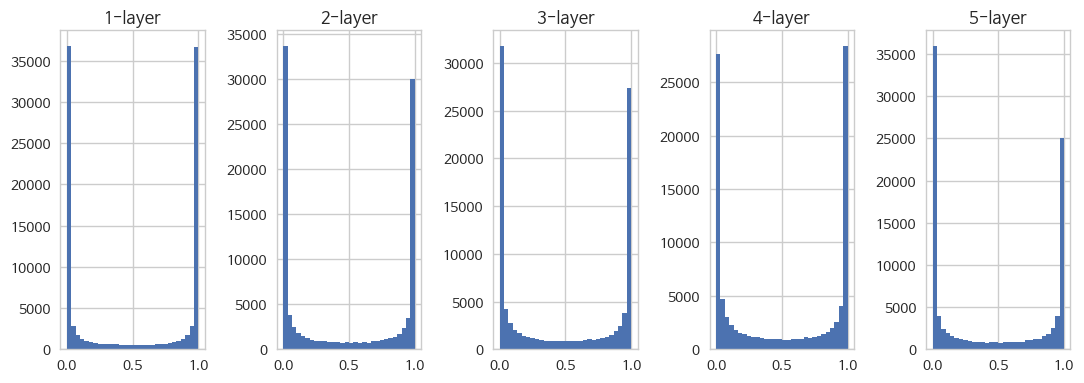

In [63]:
activations = get_activations(x, w_std=1, node_num=node_num)
plt.figure(figsize=(11, 4), dpi=100)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.tight_layout()
plt.show()

**기울기 소실(gradient vanishing) 문제:**

활성 값들의 분포가 0과 1에 치중 되어있다. 이렇게 되면 역전파의 기울기가 점점 작아지다가 소멸된다. 

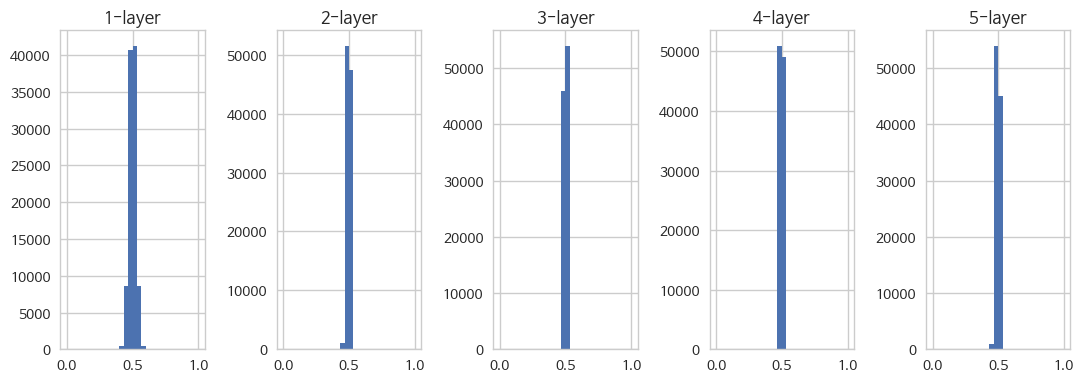

In [59]:
activations = get_activations(x, w_std=0.01, node_num=node_num)
plt.figure(figsize=(11, 4), dpi=100)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.tight_layout()
plt.show()

표준편차를 0.01로 바꾼후 분포가 0.5로 치우쳤다. 활성화 값들이 치우쳤다는 것은 표현력을 제한하는 것이다.(다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러개 둔 의미가 없어진다는 뜻이다.)

**Xavier 초깃값**

표준편차를 $\frac{1}{\sqrt{n}}$ 으로 초기화 하는 것, 보통 sigmoid, tanh 함수에 쓰인다

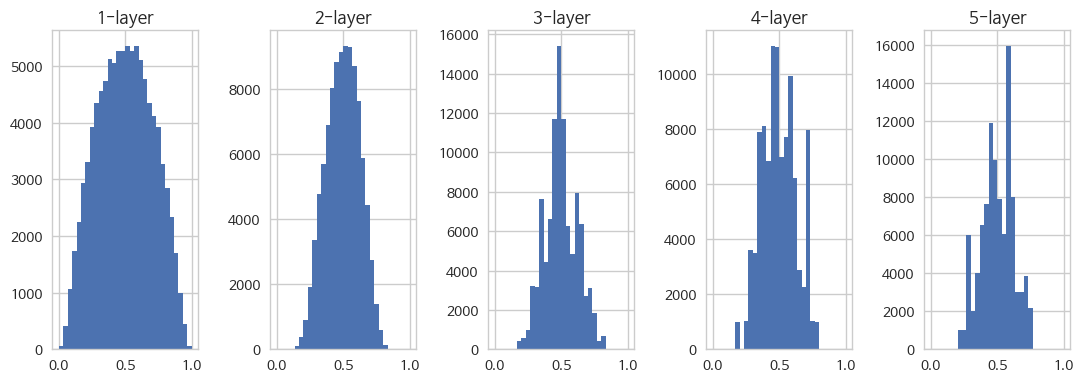

In [60]:
activations = get_activations(x, w_std=(1/np.sqrt(node_num)), node_num=node_num)
plt.figure(figsize=(11, 4), dpi=100)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.tight_layout()
plt.show()

**ReLu 특화된 초기값(He 초기값)**

표준편차를 $\sqrt{\frac{2}{n}}$ 를 사용해야한다

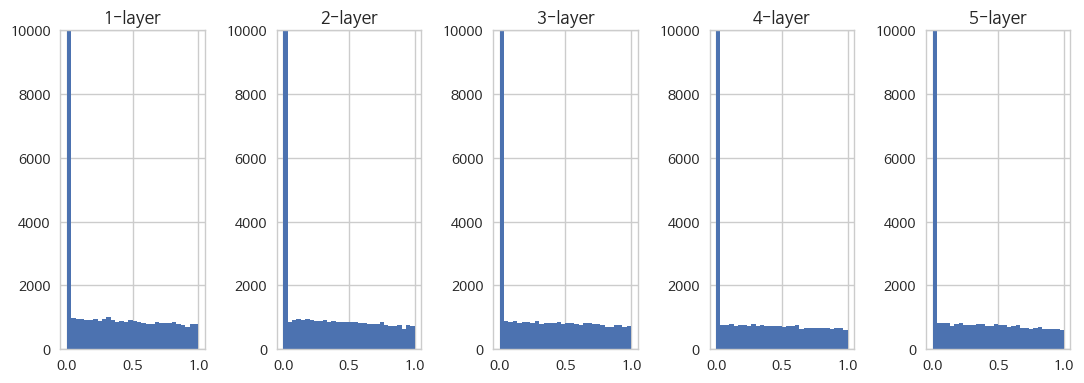

In [70]:
activations = get_activations(x, w_std=np.sqrt(2/node_num), node_num=node_num, function=ReLu)
plt.figure(figsize=(11, 4), dpi=100)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
    plt.ylim((0, 10000))
plt.tight_layout()
plt.show()

표준편차를 0.01 썻을 때랑 비교

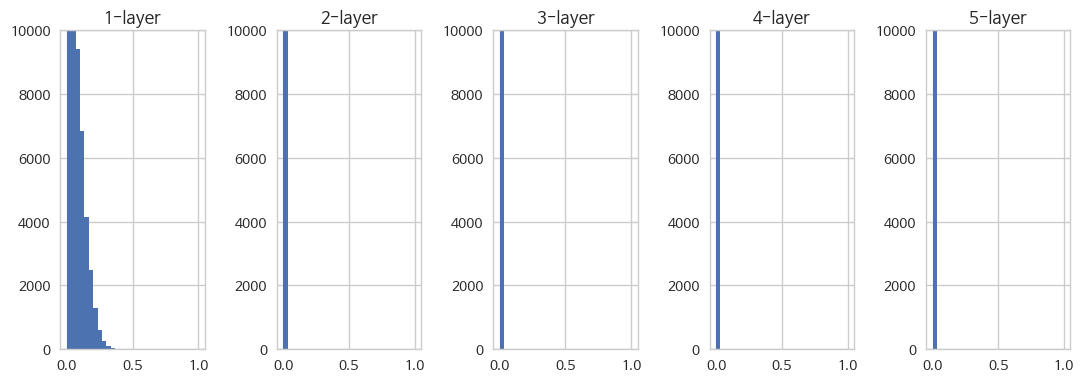

In [71]:
activations = get_activations(x, w_std=0.01, node_num=node_num, function=ReLu)
plt.figure(figsize=(11, 4), dpi=100)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
    plt.ylim((0, 10000))
plt.tight_layout()
plt.show()

### **배치 정규화**

**장점:**
* 학습을 빨리 진행 할 수 있다(학습 속도 개선).
* 초깃값에 크게 의존하지 않는다.
* 오버피팅을 억제한다(드롭아웃 등의 필요성 감소).

$$
\mu_{B} \leftarrow \frac{1}{m}\sum_{i=1}^{m}{x_i} \\
\\ 
\sigma_{B}^{2} \leftarrow \frac{1}{m}\sum_{i=1}^{m}{(x_i - \mu_B)^2} \\
\\
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^{2} + \varepsilon}}
$$
$B$ 는 미니배치다.

배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대(scale)와 이동(shift)변환을 수행한다.

$$y_i \leftarrow \gamma \hat{x_i}+\beta$$

![](./figs/NN_batchnorm.png)